In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm as cm
import seaborn as sns
import missingno as msno

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, average_precision_score
from sklearn.metrics import precision_recall_curve, roc_curve

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

from collections import defaultdict
from scipy.stats import hmean
from scipy.spatial.distance import cdist
from scipy import stats
import numbers 

import pylab # t-SNE 
import time # t-SNE model
from sklearn.manifold import TSNE # t-SNE
from sklearn.decomposition import PCA, TruncatedSVD # PCA, SVD

In [2]:
df = pd.read_csv('data/creditcard-training.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227844 entries, 0 to 227843
Data columns (total 32 columns):
Seconds since reference time       227844 non-null int64
Amount                             227844 non-null float64
Fraud? (1: Fraud, 0:  No Fraud)    227844 non-null int64
Feature 1                          227844 non-null float64
Feature 2                          227844 non-null float64
Feature 3                          227844 non-null float64
Feature 4                          227844 non-null float64
Feature 5                          227817 non-null float64
Feature 6                          227785 non-null float64
Feature 7                          227844 non-null float64
Feature 8                          227844 non-null float64
Feature 9                          227844 non-null float64
Feature 10                         227844 non-null float64
Feature 11                         227844 non-null float64
Feature 12                         227844 non-null float64
Feature 

# Exploratory Data Analysis

In [4]:
#Get shape
df.shape

(227844, 32)

In [5]:
#Print head
df.head()

,Seconds since reference time,Amount,"Fraud? (1: Fraud, 0: No Fraud)",Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,...,Feature 20,Feature 21,Feature 22,Feature 23,Feature 24,Feature 25,Feature 26,Feature 27,Feature 28,Feature 29
0,0,149.62,0,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,...,0.462388,0.239599,0.098698,-6.399372,-0.311169,-0.991390,-0.617801,-0.551600,0.090794,0.363787
1,0,2.69,0,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,...,-0.082361,-0.078803,0.085102,13.786441,-0.143772,0.489095,1.065235,1.612727,-0.166974,-0.255425
2,1,378.66,0,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,...,1.800499,0.791461,0.247676,-10.515321,-0.165946,0.717293,0.066084,0.624501,0.207643,-1.514654
3,1,123.50,0,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,...,1.247203,0.237609,0.377436,2.961038,-0.287924,0.507757,0.178228,-0.226487,-0.054952,-1.387024
4,2,69.99,0,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,...,0.095921,0.592941,-0.270533,2.751346,-1.119670,1.345852,0.538196,-0.822843,0.753074,0.817739


In [6]:
#Rename the fraud column
df = df.rename( {'Fraud? (1: Fraud, 0:  No Fraud)' : 'Fraud'}, axis=1)
df.head()

,Seconds since reference time,Amount,Fraud,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,...,Feature 20,Feature 21,Feature 22,Feature 23,Feature 24,Feature 25,Feature 26,Feature 27,Feature 28,Feature 29
0,0,149.62,0,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,...,0.462388,0.239599,0.098698,-6.399372,-0.311169,-0.991390,-0.617801,-0.551600,0.090794,0.363787
1,0,2.69,0,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,...,-0.082361,-0.078803,0.085102,13.786441,-0.143772,0.489095,1.065235,1.612727,-0.166974,-0.255425
2,1,378.66,0,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,...,1.800499,0.791461,0.247676,-10.515321,-0.165946,0.717293,0.066084,0.624501,0.207643,-1.514654
3,1,123.50,0,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,...,1.247203,0.237609,0.377436,2.961038,-0.287924,0.507757,0.178228,-0.226487,-0.054952,-1.387024
4,2,69.99,0,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,...,0.095921,0.592941,-0.270533,2.751346,-1.119670,1.345852,0.538196,-0.822843,0.753074,0.817739


In [7]:
#Get NAs 
df[df.isnull().any(axis=1)]

,Seconds since reference time,Amount,Fraud,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,...,Feature 20,Feature 21,Feature 22,Feature 23,Feature 24,Feature 25,Feature 26,Feature 27,Feature 28,Feature 29
10,10,7.80,0,0.230930,0.031967,0.253415,0.854344,NaN,-0.387226,-0.009302,...,-0.629152,-1.423236,0.048456,-13.640428,-0.095045,-0.513947,-0.671440,1.199644,1.626659,-1.720408
16,12,12.99,0,0.354574,-0.246635,-0.009212,-0.595912,-0.575682,NaN,-0.024612,...,0.288069,-0.586057,0.189380,8.579468,-0.468647,0.708380,0.936708,-0.450311,-0.267975,0.782333
25,22,26.43,0,-0.211668,-0.333321,0.010751,-0.488473,0.505751,NaN,-0.403639,...,-0.959537,0.543985,-0.104627,-10.985595,-0.279797,-0.655233,-0.180523,-0.856566,0.149451,0.475664
28,23,33.00,0,0.076804,-1.405919,0.775592,-0.942889,NaN,0.097308,0.077237,...,-0.200331,0.740228,-0.029247,-5.123601,-0.086324,0.635954,0.786796,-0.012142,-0.346188,-0.593392
42,33,14.80,0,0.235545,-1.347811,0.504648,-0.798405,0.759710,NaN,-0.087329,...,0.119168,0.850893,-0.176267,5.560997,-0.365439,0.481917,0.398299,-0.387003,0.148455,-0.243501
45,34,21.34,0,-0.075662,-0.709192,0.381219,-1.372080,NaN,-0.078355,-0.164222,...,-0.410195,-0.013898,-0.072440,-13.340241,-0.188353,0.744207,1.124304,-0.002602,-0.269953,0.306788
63,42,32.51,0,-0.172409,-0.118962,-0.550002,-0.148052,NaN,NaN,-0.257663,...,3.736574,0.316446,0.672296,-0.165037,-0.276191,-0.274214,-0.161506,-0.495120,-0.269502,0.015140
81,52,6.67,0,-0.626936,-0.369716,-0.031799,-0.215342,0.055020,NaN,-0.087813,...,0.301067,-0.132960,0.227885,-3.121531,0.502861,-1.468036,0.413362,0.645046,0.083904,0.252191
88,56,10.84,0,1.654140,-0.392648,-0.875960,0.183946,NaN,0.167231,-0.239426,...,2.796671,0.470283,0.265333,10.767055,-0.042677,-0.110867,0.017131,0.208725,-0.735586,0.919513
98,67,28.28,0,0.507764,-0.260264,0.246631,0.008856,NaN,NaN,-0.140047,...,0.258495,-0.012189,0.102136,-8.411696,-0.680510,0.208014,-0.106846,-0.550296,1.198556,-0.286164


In [8]:
#For now I'm dropping NAs. Later we'll figure out a way to deal with it
#df = df.dropna()

Text(0, 0.5, 'Frequency')

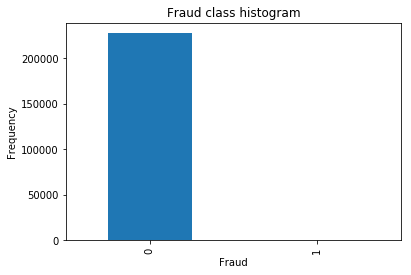

In [9]:
#Checking the Target Classes
count_classes = pd.value_counts(df['Fraud'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Fraud class histogram")
plt.xlabel("Fraud")
plt.ylabel("Frequency")

#The historgram shows that there is a need for resampling 


In [10]:
#Since the value of amount has a very different scale from the rest, we should condier normalising the column "amount"
#Method 1 Drop Seconds Since Reference Time Column
#Seconds since reference time column will be dropped as well since it has no significant contribution to the model building as it is simply a cheorogrphical order of the reference time
#df['normAmount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))
#df = df.drop(['Seconds since reference time','Amount'],axis=1)
#df.head()

#Method 2 Normalize Seconds Since Reference Time Column
df['normAmount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))
df['normTime'] = StandardScaler().fit_transform(df['Seconds since reference time'].values.reshape(-1, 1))
df = df.drop(['Amount'],axis=1)
df.head()
df = df.drop(['Seconds since reference time'],axis=1)

#Deciding which method to choose depends on ?????


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [11]:
#Get difference in means between Fraud and not-fraud
df.groupby('Fraud').mean()

,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,Feature 10,...,Feature 22,Feature 23,Feature 24,Feature 25,Feature 26,Feature 27,Feature 28,Feature 29,normAmount,normTime
Fraud,,,,,,,,,,,,,,,,,,,,,
0,0.049387,0.002841,0.028799,-0.018164,-0.008677,0.009279,-0.007071,-0.022976,-0.009824,0.001263,...,0.002776,0.026436,0.045807,0.016831,-0.032826,0.068994,0.009538,0.007167,-0.000255,0.000545
1,-0.098209,-4.559229,-7.423533,-2.589217,0.766809,0.374396,0.765659,0.013088,-0.060036,-0.083433,...,0.663762,0.613894,-7.024019,-0.048627,-6.685076,4.046820,-6.135121,-2.696376,0.139044,-0.297025


There are quite a few variables with a huge difference between the fraudulent and non-fraudulent data 

In [12]:
#Get number of fraud and not fraud values
fraud_rows = df['Fraud'].value_counts()
total_rows = df.shape[0]
percentage_fraud = fraud_rows[1]/total_rows

print("Fraud rows: ", fraud_rows[1])
print("Total rows: ", total_rows)
print("Percentage rows: ", percentage_fraud)

Fraud rows:  417
Total rows:  227844
Percentage rows:  0.0018301996102596514


<div class="alert alert-danger">
Since the dataset is quite imbalanced (fraud vs non-fraud), we will be using <b>SMOTE</b> to create some synthetic observations 
</div>

In [13]:
#Function to plot data. Will be used later
def plot_data(X, y):
    plt.scatter(X[y == 0, 0], X[y == 0, 1], label="Class #0", alpha=0.5, linewidth=0.15)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], label="Class #1", alpha=0.5, linewidth=0.15, c='r')
    plt.legend()
    return plt.show()

In [ ]:
#We will be using SMOTE only on the training dataset. Thus, we need to split now
y = df['Fraud']
X = df.drop('Fraud', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=0)

#Analysie Missing Values Pattern and do KNN Imputation 

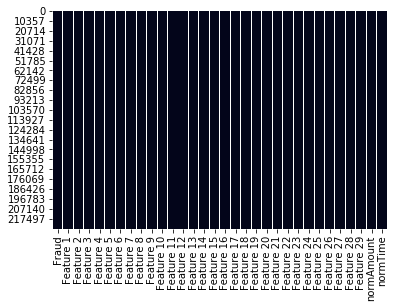

In [15]:
#Missing Values Pattern Analysis using Seaborn
sns.heatmap(df.isnull(), cbar=False)

Due to the drastic difference between the number of fraud cases and non-fraud cases, the missing values analysis is not really appropriate in this dataset. 

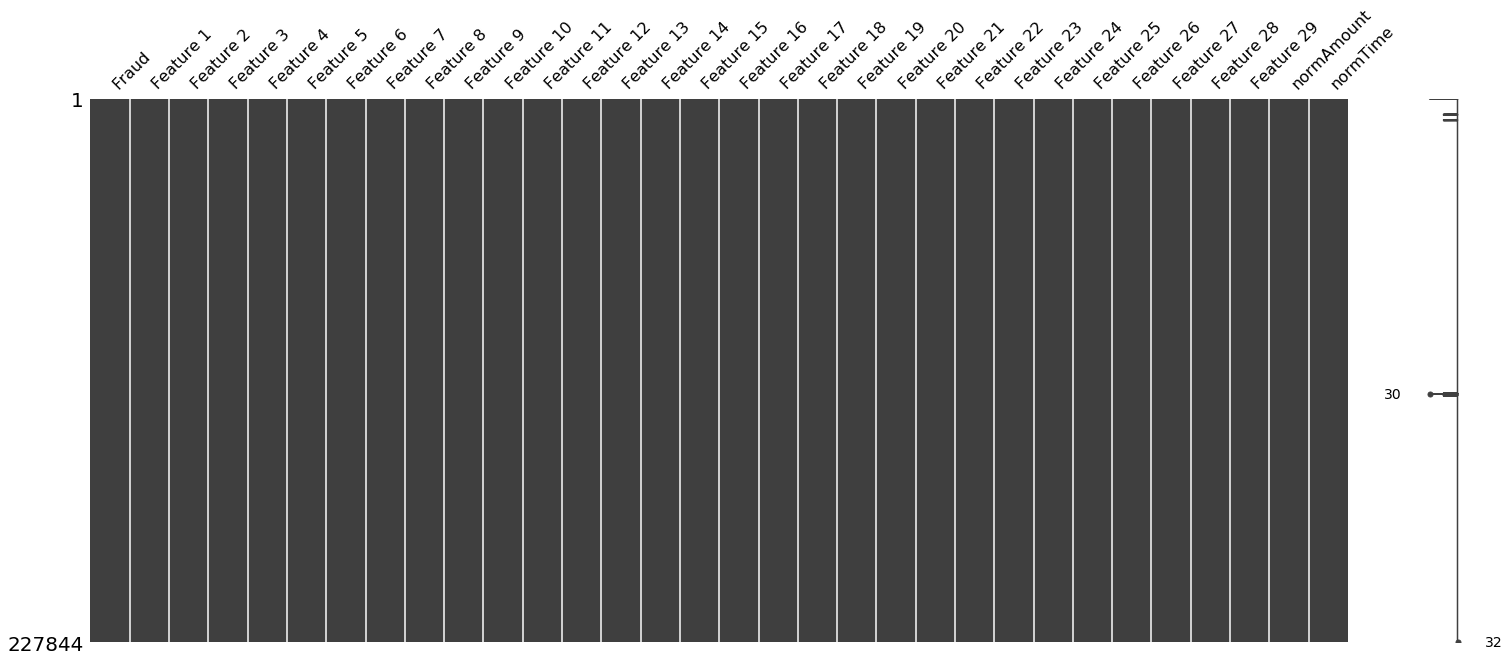

In [17]:
#Missing Values Pattern Analysis using missingno
msno.matrix(df)

Even after plotting missing values pattern using MSNO, the same analysis is resulted. Hence it is not ideal to use such method to analyse missing valeus. 

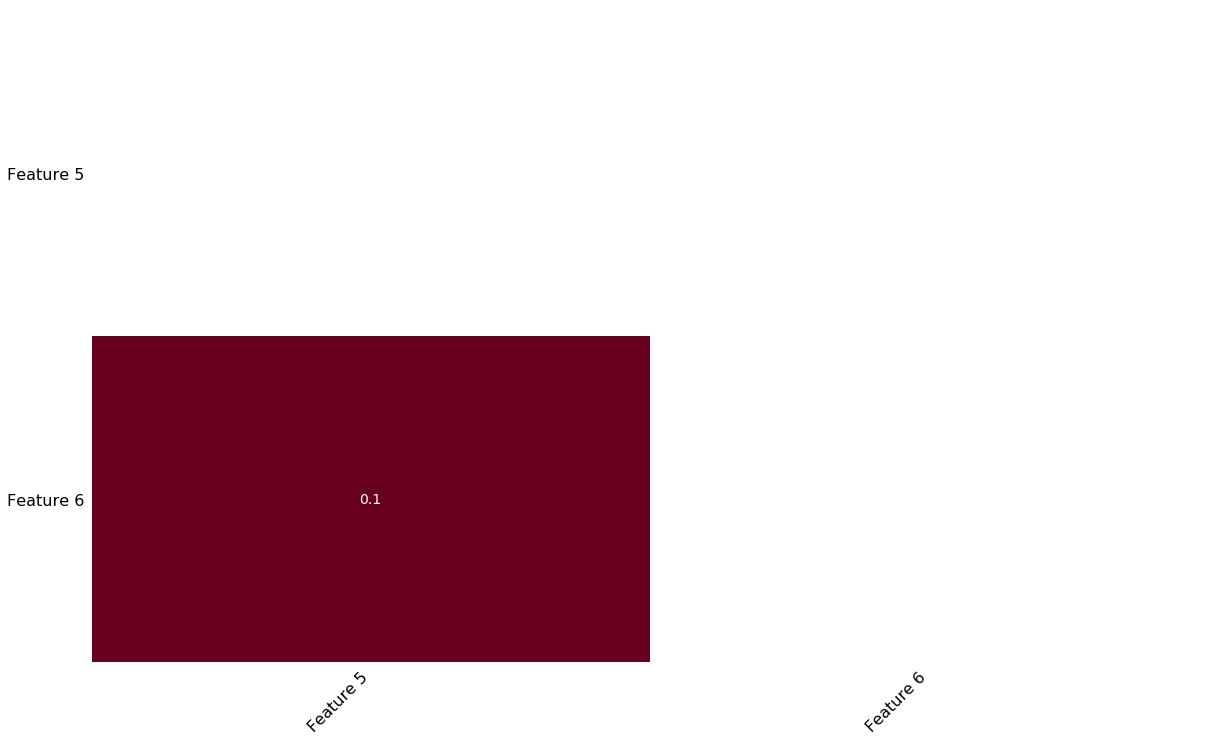

In [18]:
#Visualise the Correleation Matrix about the locations of missing values in columns 
msno.heatmap(df)

The missingno correlation heatmap measures nullity correlation: how strongly the presence or absence of one variable affects the presence of another. In this case, it shows that only Feature 6 and 5 are missing and there is a 0.1 correlation between the missing values in these two columns. 

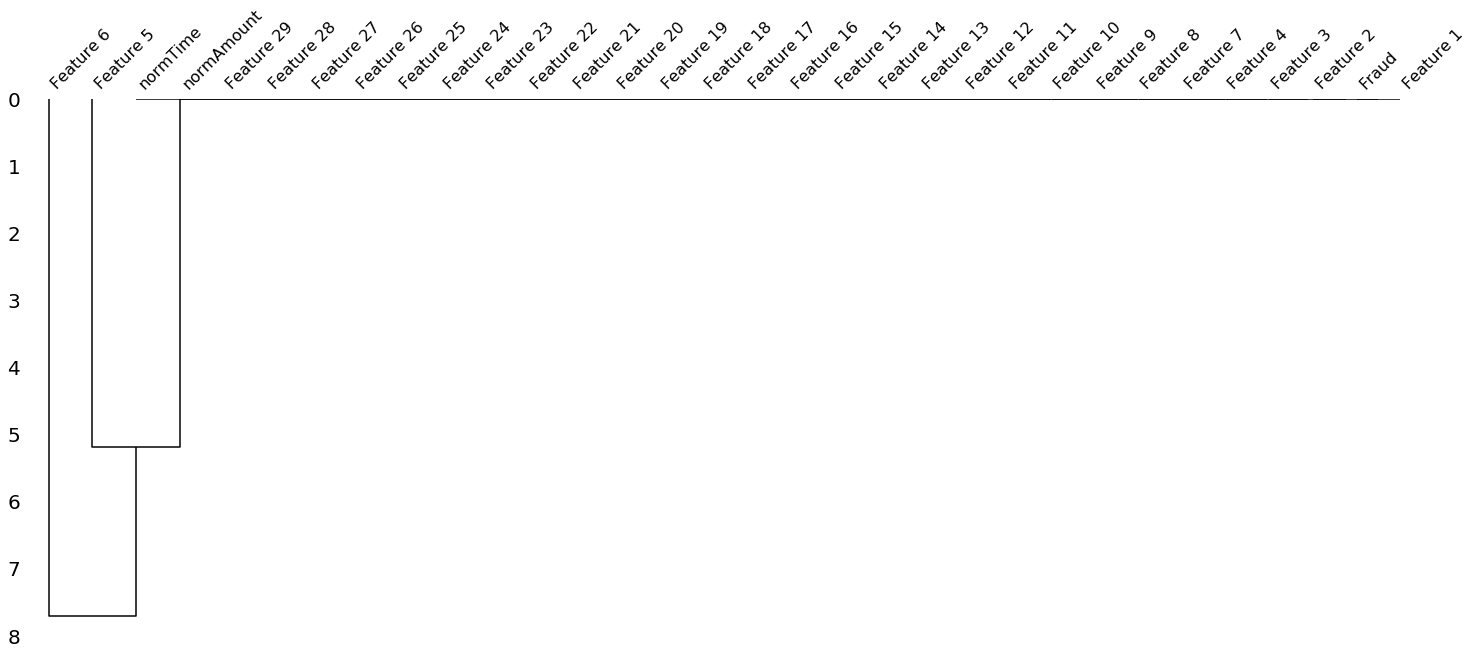

In [23]:
msno.dendrogram(df)

Interpreting Dendrogram:

The dendrogram uses a hierarchical clustering algorithm (courtesy of scipy) to bin variables against one another by their nullity correlation (measured in terms of binary distance). At each step of the tree the variables are split up based on which combination minimizes the distance of the remaining clusters. The more monotone the set of variables, the closer their total distance is to zero, and the closer their average distance (the y-axis) is to zero.

To interpret this graph, read it from a top-down perspective. Cluster leaves which linked together at a distance of zero fully predict one another's presence—one variable might always be empty when another is filled, or they might always both be filled or both empty, and so on. In this specific example the dendrogram glues together the variables which are required and therefore present in every record.

Cluster leaves which split close to zero, but not at it, predict one another very well, but still imperfectly. If your own interpretation of the dataset is that these columns actually are or ought to be match each other in nullity (for example, as CONTRIBUTING FACTOR VEHICLE 2 and VEHICLE TYPE CODE 2 ought to), then the height of the cluster leaf tells you, in absolute terms, how often the records are "mismatched" or incorrectly filed—that is, how many values you would have to fill in or drop, if you are so inclined.

Analysis:
- There is a relationship between normAmount and the missing values for Feature 5 
- There is also a relationship between missing values for Feature 5 and Feature 6

Missing Values Type Analysis 
To better able to understand the missing values pattern, we should distinguish whether the missing values are missing completely at random (MCAR), missing at random (MAR) or missing not at random (MNAR). In this case, we can notice that the missing values are definitely NOT missing completely at random since there is an association between the missing values and the observed variabels. However, as the features details are not known (only know Feature 1, 2, 3 etc), we cannot distinguish whether the missing values are Missing at Random (MAR) or Missing Not at Random (MNAR). We will continue to use multiple imputation to fill in the missing values as this is the most appropriate method

In [ ]:
#Plot Outliers in Boxplot  and Remove Outliers 

In [ ]:
#https://gist.github.com/YohanObadia/b310793cd22a4427faaadd9c381a5850
#https://towardsdatascience.com/the-use-of-knn-for-missing-values-cf33d935c637

# Data Resampling

In [ ]:
method = SMOTE(kind='regular')

# Apply resampling to the training data only
X_resampled, y_resampled = method.fit_sample(X_train, y_train)

In [ ]:
plot_data(X_resampled, y_resampled)
type(X_resampled)

In [ ]:
print("Before resampling")
print(pd.value_counts(pd.Series(y)))

# Print the value_counts
print("After resampling")
print(pd.value_counts(pd.Series(y_resampled)))

## Models to detect Fraud

In [ ]:
# Continue fitting the model and obtain predictions
model = LogisticRegression()
model.fit(X_train, y_train)

# Get your performance metrics
predicted = model.predict(X_test)

# Print the classifcation report and confusion matrix
print('Classification report:\n', classification_report(y_test, predicted))
conf_mat = confusion_matrix(y_true=y_test, y_pred=predicted)
print('Confusion matrix:\n', conf_mat)

In [ ]:
# Continue fitting the model and obtain predictions
model = LogisticRegression()
model.fit(X_resampled, y_resampled)

# Get your performance metrics
predicted = model.predict(X_test)

# Print the classifcation report and confusion matrix
print('Classification report:\n', classification_report(y_test, predicted))
conf_mat = confusion_matrix(y_true=y_test, y_pred=predicted)
print('Confusion matrix:\n', conf_mat)

## Combine Logistic regression and SMOTE

In [ ]:
# This is the pipeline module we need for this from imblearn
from imblearn.pipeline import Pipeline 

# Define which resampling method and which ML model to use in the pipeline
resampling = SMOTE(kind='borderline2')
model = LogisticRegression()

# Define the pipeline, tell it to combine SMOTE with the Logistic Regression model
pipeline = Pipeline([('SMOTE', resampling), ('Logistic Regression', model)])

# Split your data X and y, into a training and a test set and fit the pipeline onto the training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Fit your pipeline onto your training set and obtain predictions by fitting the model onto the test data 
pipeline.fit(X_train,y_train) 
predicted = pipeline.predict(X_test)

# Obtain the results from the classification report and confusion matrix 
print('Classifcation report:\n', classification_report(y_test, predicted))
conf_mat = confusion_matrix(y_true=y_test, y_pred=predicted)
print('Confusion matrix:\n', conf_mat)

## Use Random Forest

In [ ]:
# Import the random forest model from sklearn
from sklearn.ensemble import RandomForestClassifier

# Split your data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0)

# Define the model as the random forest
model_rf = RandomForestClassifier(random_state=5)

In [ ]:
# Fit the model to our training set
model.fit(X_resampled, y_resampled)

# Obtain predictions from the test data 
predicted = model.predict(X_test)

# Print the accuracy performance metric
print(accuracy_score(y_test, predicted))

## Performance Metrics

In [ ]:
# Obtain the predictions from our random forest model 
predicted = model.predict(X_test)

# Predict probabilities
probs = model.predict_proba(X_test)

# Print the ROC curve, classification report and confusion matrix
print(roc_auc_score(y_test, probs[:,1]))
print(classification_report(y_test, predicted))
print(confusion_matrix(y_test, predicted))

In [ ]:
#Calculate Average precisions
average_precision = average_precision_score(y_test, predicted)
average_precision